# 0. Import libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models.isolation_forest import IsolationForestDetector
from utils.preprocessing import AnomalyPreprocessor
from data.data_loader import AnomalyDataLoader
from utils.evaluation import AnomalyEvaluator

In [2]:
dataloader = AnomalyDataLoader('../../anomaly_detection/data')
dataset_dict = dataloader.load_all_data()
df1 = dataset_dict["dataset1"]
df2 = dataset_dict["dataset2"]

In [3]:
df1.head()

,motor_current,date
datetime,,
2021-01-01 00:01:15,7.419254,2021-01-01
2021-01-01 00:01:16,40.993702,2021-01-01
2021-01-01 00:01:17,38.593835,2021-01-01
2021-01-01 00:01:18,38.429304,2021-01-01
2021-01-01 00:01:19,37.370117,2021-01-01


In [4]:
df2.head()

,motor_current,date
datetime,,
2021-01-01 09:37:07.500,25.509920,2021-01-01
2021-01-01 09:37:08.000,27.486909,2021-01-01
2021-01-01 09:37:08.500,25.045239,2021-01-01
2021-01-01 09:37:09.000,24.345630,2021-01-01
2021-01-01 09:37:09.500,24.373838,2021-01-01


Data frequencies:
- df1: 1 second (1 Hz)
- df2: 0.5 second (2 Hz)

# 1.Exploratory Data Analysis

- Observe standart statistical values for each dataset

In [5]:
df1.describe()

,motor_current,date
count,251577.000000,251577
mean,29.116758,2021-01-07 13:07:28.567237888
min,1.000280,2021-01-01 00:00:00
25%,24.939233,2021-01-03 00:00:00
50%,28.854100,2021-01-07 00:00:00
75%,33.135217,2021-01-12 00:00:00
max,77.682145,2021-01-15 00:00:00
std,5.842852,NaN


In [6]:
df2.describe()

,motor_current,date
count,1.034973e+06,1034973
mean,2.923780e+01,2021-01-15 05:47:52.447106816
min,1.000246e+00,2021-01-01 00:00:00
25%,2.493040e+01,2021-01-08 00:00:00
50%,2.895767e+01,2021-01-15 00:00:00
75%,3.310991e+01,2021-01-23 00:00:00
max,7.946051e+01,2021-01-30 00:00:00
std,6.061458e+00,NaN


- The statistical distributions of each dataset seem similar which is expected(mean around 29 and std around 6). 

Now lets observe the daily distribution of each dataset:

<Axes: xlabel='date'>

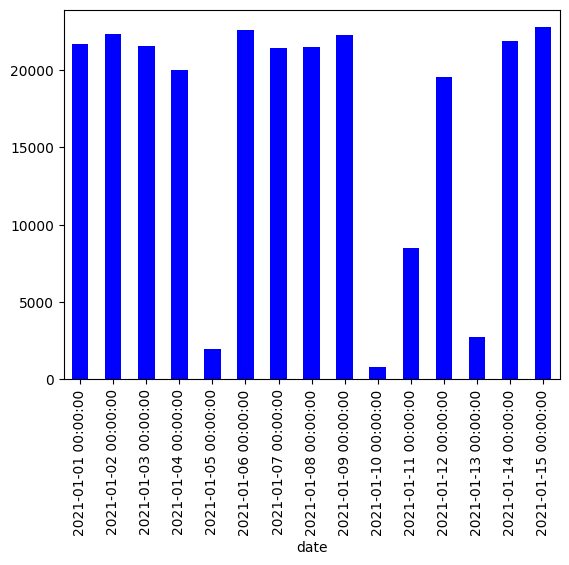

In [7]:
df1["date"].value_counts().sort_index().plot(kind='bar', color='blue')

<Axes: xlabel='date'>

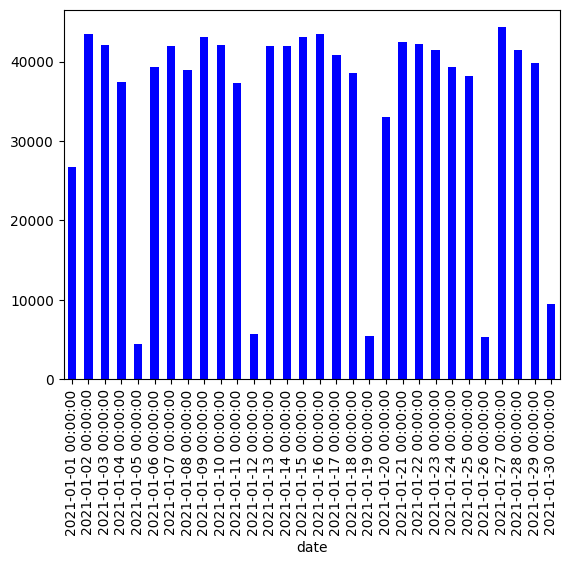

In [8]:
df2["date"].value_counts().sort_index().plot(kind='bar', color='blue')

- We can observe that there are many missing logs in some days. 
- In df2, the missing logs follow a weekly pattern starting from 5th of January. I checked the date and it is Tuesday. This may be because of holidays or maintenance days for that specific production line.

- Now that we observe the daily counts, I would like to see the mean values with resampled versions (Minutely, Hourly, Daily):

In [9]:
def plot_resamplings(df, column='motor_current'):
    df[column].plot(title='Original Data')
    plt.show()

    df[column].resample('min').mean().plot(title='Minute Resampling')
    plt.show()

    df[column].resample('h').mean().plot(title='Hourly Resampling')
    plt.show()

    df[column].resample('D').mean().plot(title='Daily Resampling')
    plt.show()

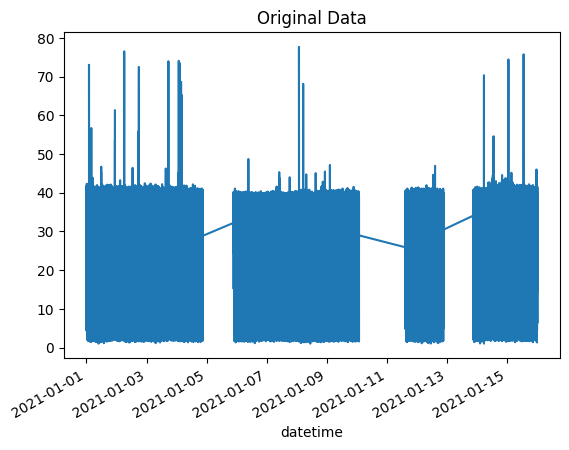

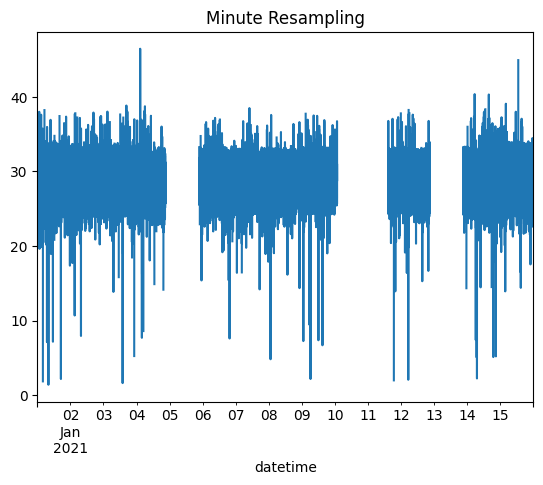

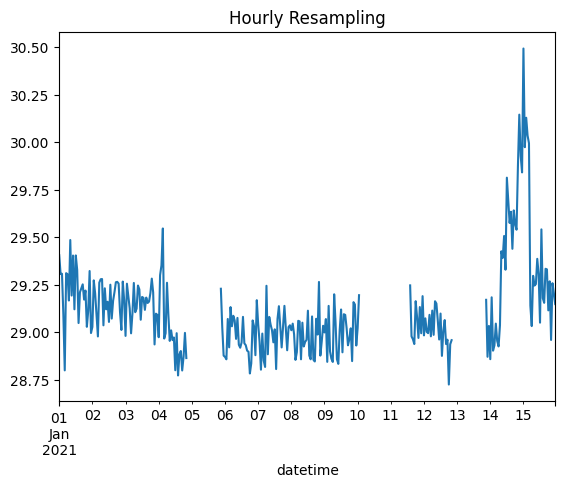

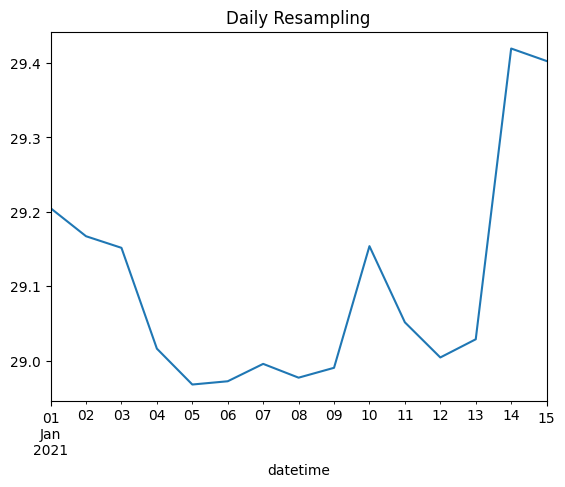

In [10]:
plot_resamplings(df1)

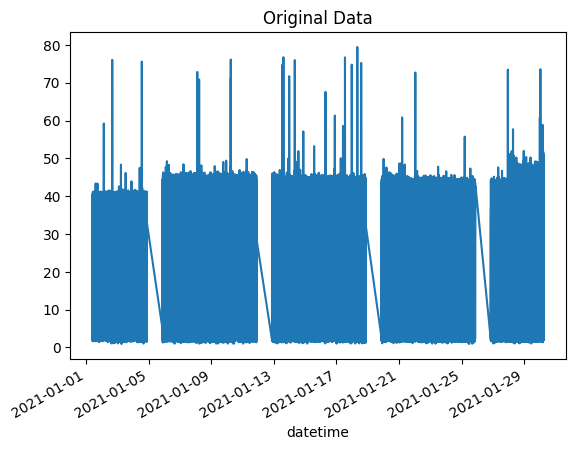

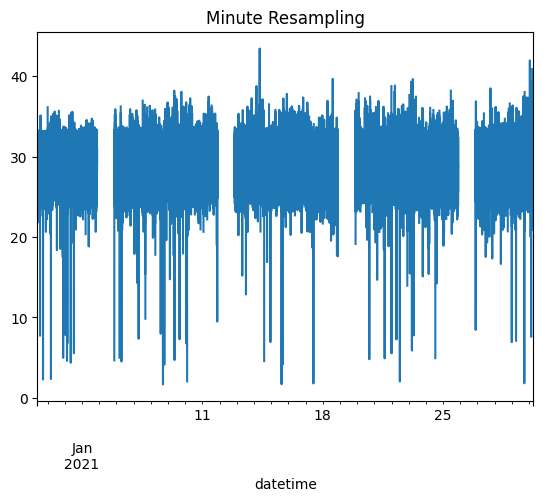

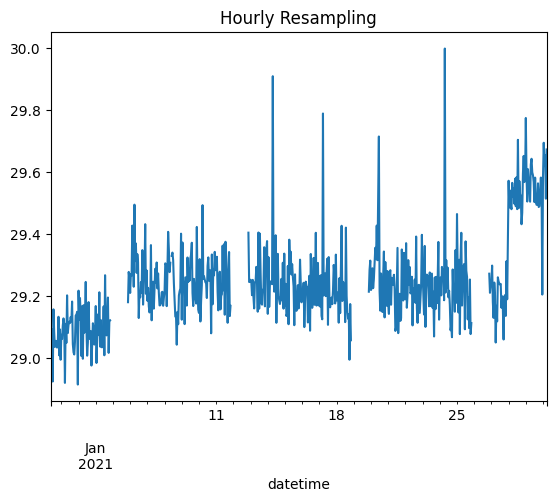

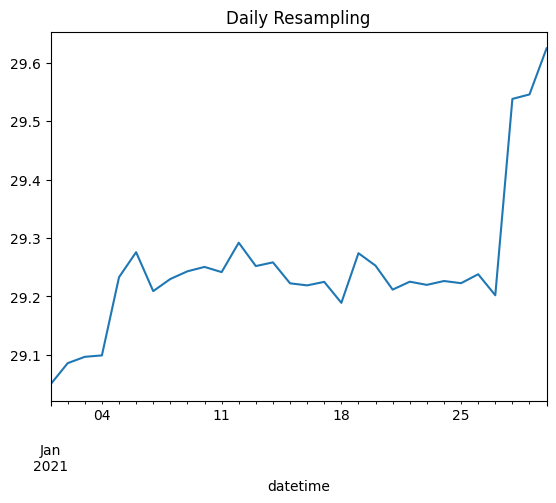

In [11]:
plot_resamplings(df2)

- You observe minutely, hourly, and daily resampled mean data. 
- Minutely data does not show anomalies properly. But hourly and daily data give tips about where the anomalies could have happened.
- If you look at daily means, the anomalies start at **13th of Jan.** for df1, and around **28th of Jan.** for df2. 
- I will assume these dates as threshold date where the anomalies start. 

# 2.Feature Engineering & Preprocessing

In [12]:
# Preprocess data
preprocessor = AnomalyPreprocessor()
df1 = preprocessor.extract_datetime_features(df1)
df1 = preprocessor.extract_statistical_features(df1)

df2 = preprocessor.extract_datetime_features(df2)
df2 = preprocessor.extract_statistical_features(df2)

In this section, the datetime and statistical features for the anomaly detection task is applied. Here are the summary of the feature engineering processes:
- 1. Datetime Feature Extraction
        - **hour**, **day**, **week** feature are added to the dataset to make the model aware of the time features.
        - I tried to add these features as cyclical features, but the performance has been reduced drastically. Thus, I decided to use the raw datetime features instead.
- 2. Statistical Feature Extraction
    - 2.1 **Moving Average(MA)**
        - Justification: Moving average smooths out short-term fluctuations and highlights long-term trends. Sudden deviations from the moving average may indicate anomalies.
        - Calculation: a window of 60*20 samples (corresponds to 20 min.) is used as rolling window. Window size is optimized during the experiments.
    - 2.2 **Standard Deviation(STD)**
        - Justification: The standard deviation measures the variability of the data. An increase in standard deviation may indicate unstable or abnormal behavior in the system.
        - Calculation: Similar to the MA, a 60*20 samples window is used. This window size is optimized during the experiments as well.
    - 2.3 **Fourier Transform (FT)**
        - Justification: The Fourier Transform decomposes the time series into its frequency components. This helps identify periodic patterns or oscillations that may be associated with anomalies. The magnitude of the FT provides a measure of the strength of these frequency components.
        - Calculation: 60*20 previous samples are used to calculate FT.

In [13]:
df1

,motor_current,date,hour,day,weekday,MA,STD,FT
datetime,,,,,,,,
2021-01-01 00:01:15,7.419254,2021-01-01,0,1,4,NaN,NaN,7.325107e+06
2021-01-01 00:01:16,40.993702,2021-01-01,0,1,4,NaN,NaN,2.414634e+04
2021-01-01 00:01:17,38.593835,2021-01-01,0,1,4,NaN,NaN,9.300681e+03
2021-01-01 00:01:18,38.429304,2021-01-01,0,1,4,NaN,NaN,1.361573e+04
2021-01-01 00:01:19,37.370117,2021-01-01,0,1,4,NaN,NaN,1.086367e+04
...,...,...,...,...,...,...,...,...
2021-01-15 23:59:41,25.186163,2021-01-15,23,15,4,29.219226,5.934531,1.043747e+04
2021-01-15 23:59:42,25.338068,2021-01-15,23,15,4,29.216205,5.935584,1.086367e+04
2021-01-15 23:59:43,25.725825,2021-01-15,23,15,4,29.213868,5.936406,1.361573e+04


In [14]:
df2

,motor_current,date,hour,day,weekday,MA,STD,FT
datetime,,,,,,,,
2021-01-01 09:37:07.500,25.509920,2021-01-01,9,1,4,NaN,NaN,3.026033e+07
2021-01-01 09:37:08.000,27.486909,2021-01-01,9,1,4,NaN,NaN,1.232902e+04
2021-01-01 09:37:08.500,25.045239,2021-01-01,9,1,4,NaN,NaN,3.205062e+04
2021-01-01 09:37:09.000,24.345630,2021-01-01,9,1,4,NaN,NaN,3.241641e+04
2021-01-01 09:37:09.500,24.373838,2021-01-01,9,1,4,NaN,NaN,3.530661e+04
...,...,...,...,...,...,...,...,...
2021-01-30 05:59:46.500,33.269684,2021-01-30,5,30,5,29.543288,6.551011,2.979606e+04
2021-01-30 05:59:47.000,32.135536,2021-01-30,5,30,5,29.546150,6.551393,3.530661e+04
2021-01-30 05:59:47.500,31.835121,2021-01-30,5,30,5,29.548569,6.551702,3.241641e+04


In [15]:
# specify split dates
df1_train_end_date = pd.to_datetime("2021-01-11")
df1_test_normal_end_date = pd.to_datetime("2021-01-13")

df2_train_end_date = pd.to_datetime("2021-01-26")
df2_test_normal_end_date = pd.to_datetime("2021-01-28")

In order to evaluate the model, I need both normal and anomaly datasets to test the actual performance. Tho do this, I split both datasets as follows:

For df1;
- Train set is the dates between **2021-01-01** and **2021-01-11** (including the 11th day).
- Normal test set is the dates between **2021-01-12** and **2021-01-13** (including the 13th day).
- Anomaly test set is the dates between **2021-01-14** and **2021-01-15**.

For df2;
- Train set is the dates between **2021-01-01** and **2021-01-26** (including the 26th day).
- Normal test set is the dates between **2021-01-27** and **2021-01-28** (including the 28th day).
- Anomaly test set is the dates between **2021-01-29** and **2021-01-30**.


In [16]:
# split data
df1_data_split_dict = dataloader.split_data(df1, df1_train_end_date, df1_test_normal_end_date)
df2_data_split_dict = dataloader.split_data(df2, df2_train_end_date, df2_test_normal_end_date)

df1_train_data = df1_data_split_dict['train']
df1_test_normal_data = df1_data_split_dict['test_normal']
df1_test_anomaly_data = df1_data_split_dict['test_anomaly']

df2_train_data = df2_data_split_dict['train']
df2_test_normal_data = df2_data_split_dict['test_normal']
df2_test_anomaly_data = df2_data_split_dict['test_anomaly']

In [17]:
# concatenate datasets
train_data = pd.concat([df1_train_data, df2_train_data]).drop(columns=["date"])
test_normal_data = pd.concat([df1_test_normal_data, df2_test_normal_data]).drop(columns=["date"])
test_anomaly_data = pd.concat([df1_test_anomaly_data, df2_test_anomaly_data]).drop(columns=["date"])

In [18]:
# scale features
train_data = preprocessor.prepare_data(train_data, scale=True, fit_scaler=True)
test_normal_data = preprocessor.prepare_data(test_normal_data)
test_anomaly_data = preprocessor.prepare_data(test_anomaly_data)

# 3. Training

Isolation Forest[1] is an unsupervised anomaly detection algorithm that uses an ensemble of decision trees to isolate anomalies directly. It identifies outliers by randomly splitting features(sampling without replacement). It assigns anomaly scores based on the average predictions of all trees, excelling at detecting rare and distinct data points.

| ![Screenshot from 2025-02-20 18-50-56.png](<attachment:Screenshot from 2025-02-20 18-50-56.png>) | ![Screenshot from 2025-02-20 18-51-55.png](<attachment:Screenshot from 2025-02-20 18-51-55.png>) |
|:---:|:---:|
| *(a) a normal point xi requires twelve random partitions to be isolated; <br> (b) an anomaly xo requires only four partitions to be isolated.* | *(c) averaged path lengths of xi and xo converge when the number of trees increases.* |





[1] F. T. Liu, K. M. Ting and Z. -H. Zhou, "Isolation Forest," 2008 Eighth IEEE International Conference on Data Mining, Pisa, Italy, 2008, pp. 413-422, doi: 10.1109/ICDM.2008.17. keywords: {Application software;Credit cards;Detectors;Constraint optimization;Data mining;Information technology;Laboratories;Isolation technology;Performance evaluation;Astronomy;anomaly detection;outlier detection;novelty detection;isolation forest;binary trees;model based},


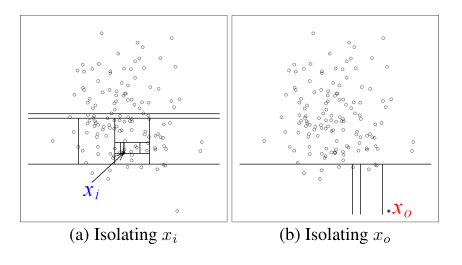
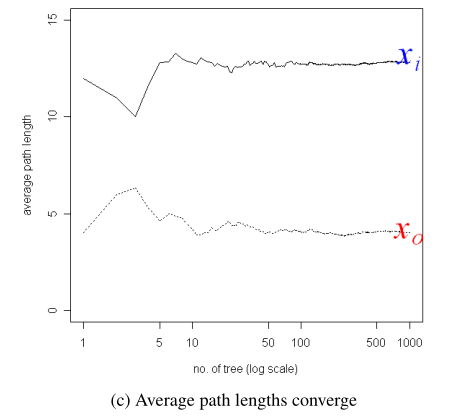

In [19]:
# train normal set on isolation forest
params = {
    "n_estimators": 100, # number of trees
    "max_samples": "auto", # subsampling size : min(256, n_samples)
    "contamination": "auto", # 0.15
    "max_features": 1.0,
    "bootstrap": True,
    "n_jobs": -1,
    "random_state": 42,
    "verbose": 1,
}
clf = IsolationForestDetector(**params)
clf.fit(train_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


- There are 2 main parameters in isolation forest model: number of trees and subsampling size. I fine tuned these parameters manually and obtained the best results with:
    - n_estimators: 100
    - max_samples: "auto" (min(256, n_samples))

max_samples is basically the size of the subsample. I selected the default value in the documentation which is 256.

# 4. Results & Conclusion

- Recall that we obtained the normal and anomaly test sets in Section 2. Now that we have a trained model, it is time to measure the performance.
- In the cell below, I first extract the scores and predictions for each test set. The threshold for the scores are determined according to the statistical distribution of the train set assuming the 10% of the train set is anomalous data. Thus, we have a logical threshold that we can use on the test sets.

In [20]:
clf.threshold

-0.5207865956635016

In [21]:
# predict on test normal set
test_normal_scores = clf.score_samples(test_normal_data)
test_normal_predictions = clf.predict(test_normal_data)

# predict on test anomaly set
test_anomaly_scores = clf.score_samples(test_anomaly_data)
test_anomaly_predictions = clf.predict(test_anomaly_data)

# evaluate model
y_true = np.concatenate([np.zeros(len(test_normal_data)), np.ones(len(test_anomaly_data))])
y_pred = np.concatenate([test_normal_predictions, test_anomaly_predictions])
scores = np.concatenate([test_normal_scores, test_anomaly_scores])

evaluator = AnomalyEvaluator()
metrics = evaluator.calculate_metrics(y_true, y_pred, scores)

print(f"True Positive: {metrics['true_positive']}")
print(f"False Positive: {metrics['false_positive']}")
print(f"True Negative: {metrics['true_negative']}")
print(f"False Negative: {metrics['false_negative']}")
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")
print(f"F1 Score: {metrics['f1_score']}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


True Positive: 102177
False Positive: 22686
True Negative: 54921
False Negative: 36017
Precision: 0.8183128709065135
Recall: 0.7393736341664616
F1 Score: 0.7768430416221579


- The final results are as follows:

Performance metrics:
- True Positive: 102177
- False Positive: 22686
- True Negative: 54921
- False Negative: 36017

Model evaluation:
- Precision: 0.818
- Recall: 0.739
- F1 Score: 0.777